# 3D Quasi-Biennial Oscillation (QBO) using ECMWF ERA-20C

In this tutorial we will explore the ERA-20C dataset provided by ECMWF. In particular, we will try to identify the so-called Quasi-Biennial Oscillation (QBO), that has a period of approximately 28 to 29 months. QBO has a characteristic quasi-periodic reversals of the zonal-mean zonal winds in the equatorial stratosphere between easterlies and westerlies with a distinct apparent downward phase propagation of the alternating wind regimes, see for example *Baldwin et al., The quasi-biennial oscillation, 2003*, and  *Schmidt et al., Spectral Empirical Orthogonal Function Analysis of Weather and Climate Data, 2019*

This mode of variability has important implications in terms of tele-connections in the Northern Hemisphere, and can be identified by using the 10hPa zonal component of the wind velocity. In particular, we will use monthly mean reanalysis data from 1900 to 2010, defined on 240 longitude points, 121 latitude points, and 18 vertical levels. 

## Download data

The first step to use `PySPOD` for investigating the Quasi-Biennial Oscillation (QBO) is to download the relevant data. This step can require a few hours, depending on your internet connection and on how busy ECMWF server is. Also, please note that the amount of data that needs to be downloaded is approximately 1.30GB. 

In order to download the required data from ECMWF, you should create an account and follow the instructions here: https://confluence.ecmwf.int/display/WEBAPI/Access+ECMWF+Public+Datasets

Once you have an account to access ECMWF data, you can simply run:
`python3 E20C_MONTHLYMEAN00_1900_2010_U131128_3D.py`

This should download a netCDF file called `E20C_MONTHLYMEAN00_1900_2010_U131128_3D.nc` in the current directory `tutorials/climate/ERA20C_QBO_3D/`. Please, make sure that this is the case. 

## Loading and configuring data

Once we have gained access to ECMWF datasets and downloaded the required file `E20C_MONTHLYMEAN00_1900_2010_U131128_3D.nc`, we can proceed to use `PySPOD` to identify coherent structures in the data. The first step from this perspective is to import the required libraries, including the custom libraries 
- `from pyspod.spod_low_storage import SPOD_low_storage`
- `from pyspod.spod_low_ram     import SPOD_low_ram`
- `from pyspod.spod_streaming   import SPOD_streaming`

that include three different implementations of the SPOD algorithm, the first requiring low storage memory (intended for large RAM machines or small amount of data), the second requiring low RAM (intended for large dataset or small RAM machines), and the third being a streaming algorithm, that required little amount of memory (both storage and RAM) but runs typically slower than the other two.

Note that we also import the custom library 
- `import library.weights as weights`

that implements the weight matrix for data defined on a sphere (e.g. the atmospheric data we are using). 

In [1]:
import os
import sys
import time
import warnings
import xarray as xr
import numpy  as np
from pathlib import Path

# Current path
CWD = os.getcwd()

# Import library specific modules
sys.path.append("../../../")
from pyspod.spod_low_storage import SPOD_low_storage
from pyspod.spod_low_ram     import SPOD_low_ram
from pyspod.spod_streaming   import SPOD_streaming
import pyspod.utils_weights as utils_weights

We then need to load the data from the netCDF file and inspect:

In [2]:
# Inspect and load data 
file = os.path.join(CWD, 'E20C_MONTHLYMEAN00_1900_2010_U131128_3D.nc')
ds = xr.open_dataset(file)
print(ds)

<xarray.Dataset>
Dimensions:    (latitude: 121, level: 18, longitude: 240, time: 1332)
Coordinates:
  * longitude  (longitude) float32 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
  * latitude   (latitude) float32 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * level      (level) int32 1 5 10 50 100 150 200 ... 750 800 850 900 950 1000
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2010-12-01
Data variables:
    u          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-04-15 04:32:04 GMT by grib_to_netcdf-2.21.0: grib_to_n...


the netCDF file contains **4 coordinates**:
- longitude,
- latitude,
- level,
- time, 

along with **1 variables**:

- u (zonal component of wind velocity).

We first load `time`, and the three spatial coordinates `longitude`, `latitude` and `level` (the latter being the vertical coordinate), and we store them into three different arrays, `t`, `x1`, `x2` and `x3`, respectively. Let's look at their dimensions to see the number of time snapshots, and the length of longitude, latitude and vertical levels.

In [3]:
# we extract time, longitude and latitude
t = np.array(ds['time'])
x1 = np.array(ds['longitude'])
x2 = np.array(ds['latitude'])
x3 = np.array(ds['level'])
print('shape of t (time): ', t.shape)
print('shape of x1 (longitude): ', x1.shape)
print('shape of x2 (latitude) : ', x2.shape)
print('shape of x3 (level)    : ', x3.shape)

shape of t (time):  (1332,)
shape of x1 (longitude):  (240,)
shape of x2 (latitude) :  (121,)
shape of x3 (level)    :  (18,)


We then need to load the data in a format that is suitable to the `PySPOD` library, that is
- first dimension must correspond to the number of time snapshots (1332 in our case)
- last dimension should corresponds to the number of variables (1 in our case)
- the remaining dimensions corresponds to the spatial dimensions (240, 121, and 18 in our case, that correspond to longitude, latitude and vertical levels).

Let's load and reshuffle it, in order to meet this requirement, and check its dimensions. 

In [4]:
# we set the variables we want to use for the analysis
# (we select all the variables present) and load the in RAM
variables = ['u']
X = np.empty([t.shape[0], x1.shape[0], x2.shape[0], x3.shape[0], len(variables)])
for i,var in enumerate(variables):
    X[...,i] = np.einsum('tijk->tkji', np.array(ds[var]))
    X[...,i] = np.nan_to_num(X[...,i])
print('shape of data matrix X: ', X.shape)

shape of data matrix X:  (1332, 240, 121, 18, 1)


We can see that: 
- the **first dimension is 1332**, and corresponds to the **number of time snapshots**; 
- the **second is 240**, and corresponds to the **number of longitude points**;
- the **third is 121**, and corresponds to the **number of latitude points**;
- the **fourth is 18**, and corresponds to the **number of vertical levels**;
- the **fourth is 6**, and corresponds to the **number of variables**.

Indeed, we use as first dimension the number of time snapshots, as last dimension the number of variables and as middle dimensions, the spatial dimensions, that in our case are three and correspond to longitude, latitude and vertical levels.

<font color='green'> **NOTE: we used `np.nan_to_num` to set possible NaN (not-a-number) to zero. The amount of NaN in this case is relatively small, and setting them to zero is a feasible approximation. For your specific application you might want to apply a different replacement for NaN (if present).**</font>

<font color='green'> **NOTE II: we also used `np.einsum` in order to match the axes dimensions to the dimensions of the data, i.e. to obtain a matrix shape $1332 \times 240 \times 121 \times 18$.**</font>

It is important to note at this point that we loaded all the required 
data into RAM, and stored it into a `numpy.ndarray`. We will later pass 
this array to the constructor of the `PySPOD` class for running our analysis. 
However, we could have used a different approach to load the data. In fact, 
the constructor to the `PySPOD` class accepts an argument called `data_handler`, 
that points to a function whose objective is to read the data at run time. 
This is particularly useful for large datasets, where it might be not possible 
to load all the data in RAM upfront. Therefore, in this case, we could simply 
define a data reader function as the following:

```python
def read_data(data, t_0, t_end, variables): 
    if t_0 == t_end: ti = [t_0]
    else           : ti = np.arange(t_0,t_end)
    print('ti =' , ti)
    X = np.empty([len(ti), x2.shape[0], x1.shape[0], len(variables)])
    for i,var in enumerate(variables):
        X = np.einsum('tijk->tkji', np.array(ds[var].isel(time=ti)))
        X = np.nan_to_num(X)
    return X
```

and pass it to the `PySPOD` constructor under the argument `data_handler`. 
The path to the data file, will then be specified in place of the data, 
under the argument `X`. See below, when we setup the analysis and call 
the constructor for a more detailed explantion of the parameters `X` 
and `data_handler`. In summary, if `X` is a numpy.ndarray containing 
your data, `data_handler` is set to `False`, if `X` is a `str` containing 
the path to your data file, `data_handler` is a function that reads your 
data, and whose arguments must be: (1.) `str` containing the path to the 
data file, (2) `int` containing the start time snapshot for slicing 
the data sequentially at run time, (3) `int` containing the end time 
snapshot for slicing the data sequentially at run time, and (4) a 
`list` containing the name of the variables in your data file. 

## Setting required and optional parameters

Once our data is in a shape suitable to the `PySPOD` library, we define the **required** and **optional parameters**. In particular, we define a dictionary of parameters, that will be passed to the constructor of `PySPOD`. 

The required parameters are as follows:
- `time_step`: time-sampling of the data (for now this must be constant)
- `n_snapshots`: number of time snapshots
- `n_space_dims`: number of spatial dimensions
- `n_variables`: number of variables
- `n_DFT`: length of FFT blocks

The optional parameters are as follows:
- `overlap`: dimension of the overlap region between adjacent blocks in percentage (0 to 100)
- `mean_type`: type of mean to be subtracted from the data (`longtime`, `blockwise` or `zero`)
- `normalize_weights`: weights normalization by data variance
- `normalize_data`: normalize data by variance
- `n_modes_save`: number of modes to be saved
- `conf_level`: calculate confidence level of modes
- `reuse_blocks`: whether to attempt reusing FFT blocks previously computed (if found)
- `savefft`: save FFT blocks to reuse them in the future (to save time)
- `savedir`: where to save the data


<font color='green'> **Note: we used the built-in module `utils_weights`, and in particular the function `utils_weights.geo_trapz_2d` to construct the weights for our problem on the sphere. This function builds weights according to lon-lat grids on the sphere and can be generally used for  two-dimensional atmospheric data. You can implement your own weights into the `custom` function inside `utils_weights.py` or by readily providing the weights as a numpy.ndarray. The weights must have a shape equal to the data spatial dimensions $\times$ number of variables, that is:**
    
$$\textsf{weights dim} = \textsf{spatial shape} \times \textsf{number of variables} = 240 \times 121 \times 18 \times 1 $$. </font>

In [5]:
# define required and optional parameters
params = dict()

# -- required parameters
params['time_step'   ] = 744                # data time-sampling
params['n_snapshots' ] = t.shape[0]       	# number of time snapshots (we consider all data)
params['n_space_dims'] = X[0,...,0].ndim    # number of spatial dimensions (longitude and latitude)
params['n_variables' ] = len(variables)     # number of variables
params['n_DFT'       ] = np.ceil(12 * 12)   # length of FFT blocks (100 time-snapshots)

# -- optional parameters
params['overlap'          ] = 0 			# dimension block overlap region
params['mean_type'        ] = 'longtime' 	# type of mean to subtract to the data
params['normalize_weights'] = False        	# normalization of weights by data variance
params['normalize_data'   ] = False   		# normalize data by data variance
params['n_modes_save'     ] = 5      		# modes to be saved
params['conf_level'       ] = 0.95   		# calculate confidence level
params['reuse_blocks'     ] = False 		    # whether to reuse blocks if present
params['savefft'          ] = False   		# save FFT blocks to reuse them in the future (saves time)
params['savedir'          ] = os.path.join(CWD, 'results', Path(file).stem) # folder where to save results

# Set weights
weights = utils_weights.geo_trapz_3D(
	x1_dim=x2.shape[0], x2_dim=x1.shape[0], x3_dim=x3.shape[0],
	n_vars=len(variables), R=1)

## Running the SPOD analysis

Once we have loaded the data and defined the required and optional parameters, we can perform the analysis. This step is accomplished by calling the `PySPOD` constructor, `SPOD_low_storage(data=X, params=params, data_handler=False, variables=variables, weights=weights)` and the `fit` method, `SPOD_analysis.fit()`. 

The `PySPOD` constructor takes `X`, that can either be a `numpy.ndarray` containing the data or the path to the data file , the parameters `params`, a parameter called `data_handler` that can be either `False` or a function to read the data, `variables` that is the list containing the names of our variables, and `weights` that contains the weights to compute the inner product required by the SPOD algorithm. If, as `data_handler`, we pass `False`, then we need to load the entire matrix of data into RAM, and that must comply with the **PySPOD** input data requirements (i.e. the dimension of the data matrix must correspond to (time $\times$ spatial dimension shape $\times$ number of variables). 

In more detail, the arguments to the constructor are defined as follows:

  - `X`: it can either be a `numpy.ndarray` and contain all data required for the analysis or a `str` containing the path to the data file. If we pass a `numpy.ndarray`, its dimensions must be equal to (time $\times$ spatial dimension shape $\times$ number of variables), and the argument `file_handler` must be set to `False`. If we pass a `str` containing the path to the data file, we need also to provide a data reader through the argument `data_handler`. The data reader must conform to reading the file and storing the data in memory according to the shape of data just described: **(number of time snapshots $\times$ shape of spatial dimensions $\times$ number of variables)**. Note that the template for the data reader must have as first argument the path to the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. An example of data reader was provided above. You can readily modify it according to your needs. See the sections above for a template example of the data reader function.
  - `params`: must be a dictionary and contains the parameters that we have just defined. 
  - `data_handler`: can be either `False` or a function handler. If it is a function handler, it must hold the function to read the data. The template for the function to read the data must have as first argument the data file, as second and third the time indices through which we will slice the data in time, and as fourth argument a list containing the name of the variables. See hour data reader as an example and modify it according to your needs.
  - `variables`: is a list containing our variables. 
  - `weights`: is a np.ndarray of shape = spatial dimensions $\times$ number of variables = 240 $\times$ 121 $\times$ 18 $\times$ 1

The `fit()` method returns a `PySPOD` object containg the results. 

In [6]:
# Perform SPOD analysis using low storage module
SPOD_analysis = SPOD_low_ram(
	data=X,
	params=params,
	data_handler=False,
	variables=variables,
	weights=weights)

# Fit SPOD
spod = SPOD_analysis.fit()


SPOD parameters
------------------------------------
Problem size               :  5.187563896179207 GB. (double)
No. of snapshots per block :  144
Block overlap              :  0
No. of blocks              :  9
Windowing fct. (time)      :  hamming
Weighting fct. (space)     :  geo_trapz_3D
Mean                       :  longtime
Number of frequencies      :  73
Time-step                  :  744
Time snapshots             :  1332
Space dimensions           :  3
Number of variables        :  1
Normalization weights      :  False
Normalization data         :  False
Number of modes to be saved:  5
Confidence level for eigs  :  0.95
Results to be saved in     :  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/ERA20C_QBO_3D/results/E20C_MONTHLYMEAN00_1900_2010_U131128_3D
Save FFT blocks            :  False
Reuse FFT blocks           :  False
Spectrum type             :  one-sided (real-valued signal)
------------------------------------

 
Calculating temporal DFT (low_ram)
------------

computing frequencies:   0%|          | 0/73 [00:00<?, ?it/s]

------------------------------------
 
Calculating SPOD (low_ram)
------------------------------------
- Memory required for storing modes ~ 5.686068534851083 GB
- Available storage memory          ~ 241.34057998657264 GB


computing frequencies: 100%|██████████| 73/73 [00:28<00:00,  2.57it/s]


------------------------------------
 
Results saved in folder  /Users/gian/GIT-GM/pyspod-review/tutorials/climate/ERA20C_QBO_3D/results/E20C_MONTHLYMEAN00_1900_2010_U131128_3D/nfft144_novlp0_nblks9
Elapsed time:  68.29240798950195 s.


## Postprocessing and visualizing results

The results are stored in a `PySPOD` objcet that is composed by: 
- a set of eigenvalues per each frequency computed, and 
- a set of modes, per each frequency computed. 

In order to visualize them, we can use the built-in plotting functionalities of `PySPOD`.
We first select the frequency (equivalently period T_approx), that we want to investigate, and identify the nearest frequency in the results by using the built-in functions `find_nearest_freq`, and `get_modes_at_freq`, that are part of the `postprocessing` module, and can be directly called from the `PySPOD` object returned once the `fit` method has completed.

In [7]:
# Show results
T_approx = 744 # approximate period (in days)
freq_found, freq_idx = spod.find_nearest_freq(freq_required=1/T_approx, freq=spod.freq)
modes_at_freq = spod.get_modes_at_freq(freq_idx=freq_idx)

- RAM required for loading all modes ~ 5.608177185058603 GB
- Available RAM memory               ~ 16.451965332031275 GB


We can then plot the **eigenvalues in the complex plane**, using the built-in function `plot_eigs`, that is part of the `postprocessing` module. We note that the eigenvalues are all real.

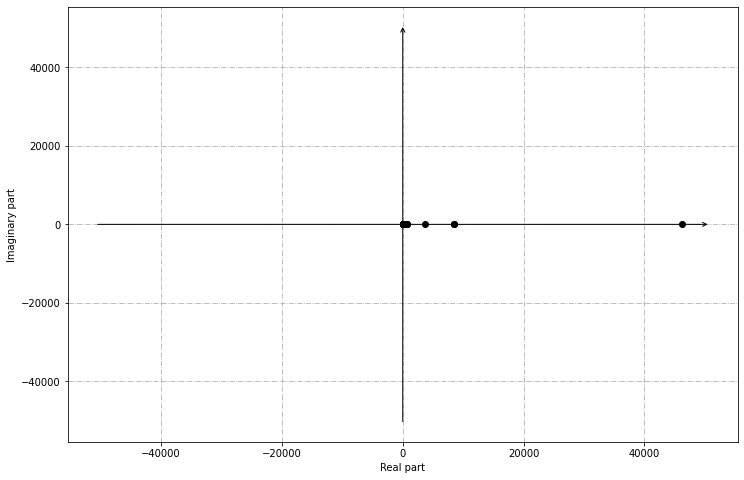

In [8]:
spod.plot_eigs()

We can then plot the **eigenvalues as a function of frequency and period** (note that we multiply the frequency by 24, that is the number of hours in a day, to obtain a period for the x-axis in days). Again, we can see how thorough the `PySPOD` object returned after the computation we can access the frequency array (`spod.freq`) along with the plotting methods `spod.plot_eigs_vs_frequency` and `spod.plot_eigs_vs_period`.

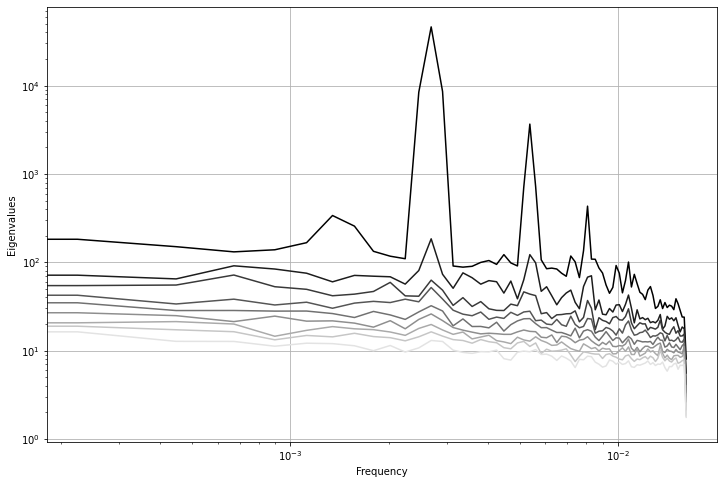

In [9]:
freq = spod.freq*24
spod.plot_eigs_vs_frequency(freq=freq)

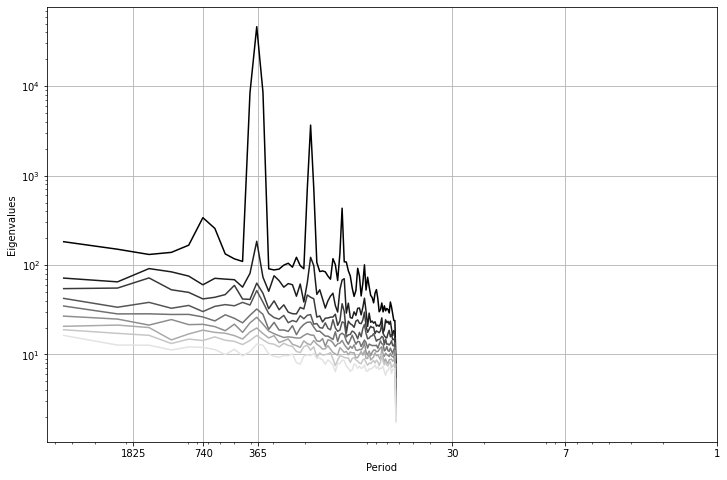

In [10]:
spod.plot_eigs_vs_period   (freq=freq, xticks=[1, 7, 30, 365, 740, 1825])

From the plot Eigenvalues vs. Period above, we can notice a peak in the spectrum at approximately 2 years, that may correspond to QBO (although it falls short of the expected 28 to 29 months, likely due to the sparsity of the data in time).

We can then plot the **modes** that were computed by the SPOD algorithm at the frequency corresponding to the frequency peak of ~740 days. This can be achieved via the built-in `plot_3D_modes_slice_at_frequency` method, that can again be accessed via the `PySPOD` object returned after the computation. To this method, we pass the frequency of the modes we are interested in. This corresponds to the frequency associated to the T_approx of 740 days that we requested, and stored in the variable `freq_found`. We also pass the `vars_idx` corresponding to the variable we are interested in, `modes_idx` corresponding to the modes we are interested in, as well as `x1`, `x2`, `x3`, that correspond to longitude, latitude and vertical levels, `slice_dim` that is the axis we want to project the 3D data onto a 2D plane (`slice_dim=2` means that we are going to view a 2D longitude-latitude plane for a given vertical level), `slice_id` that is the id of the plane we want to visualize (`slice_dim=2`, `slice_id=2`, means that we are going to visualize the longitude-latitude place for the third vertical level). We finally pass a parameter `coastlines='centred'`, that overlays a world map on top of our data (this is true only for `slice_dim=2`, as it does not make sense to overlay a world map in the vertical direction). Note that we **shift longitude of 180**, as we use coastlines that goes from -180, to 180, while our data was provided from 0 to 360. 

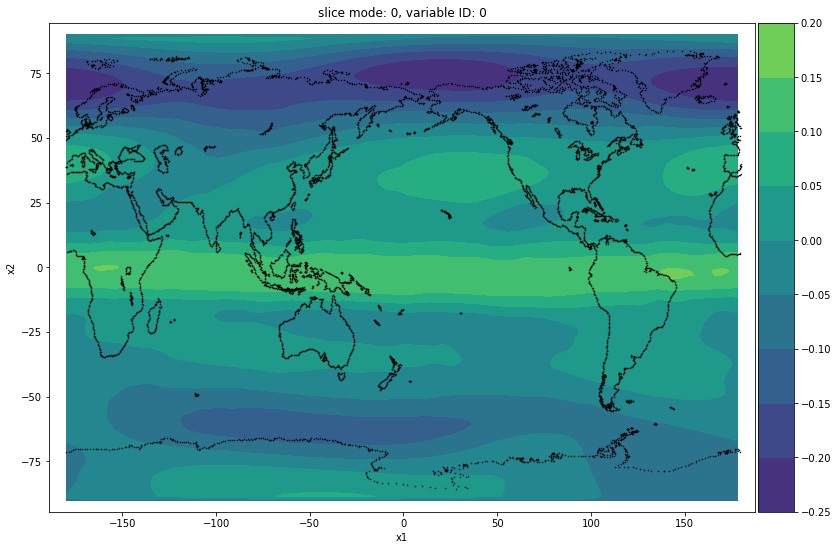

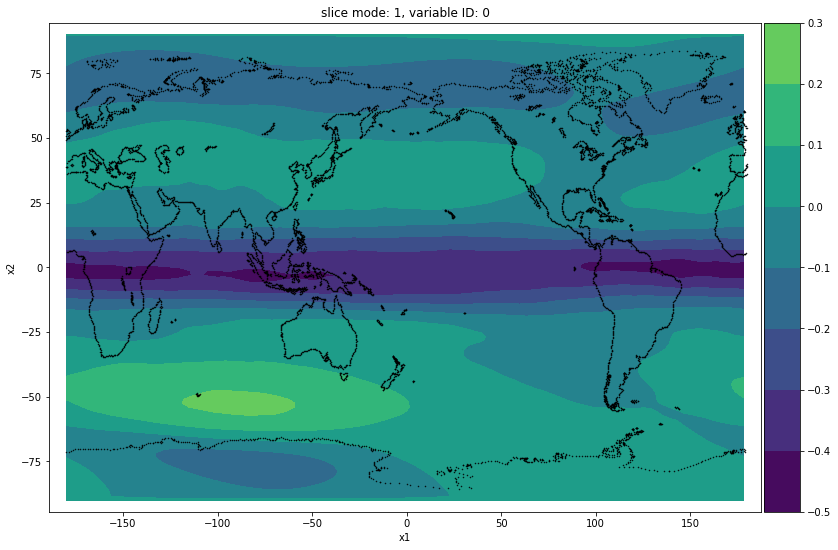

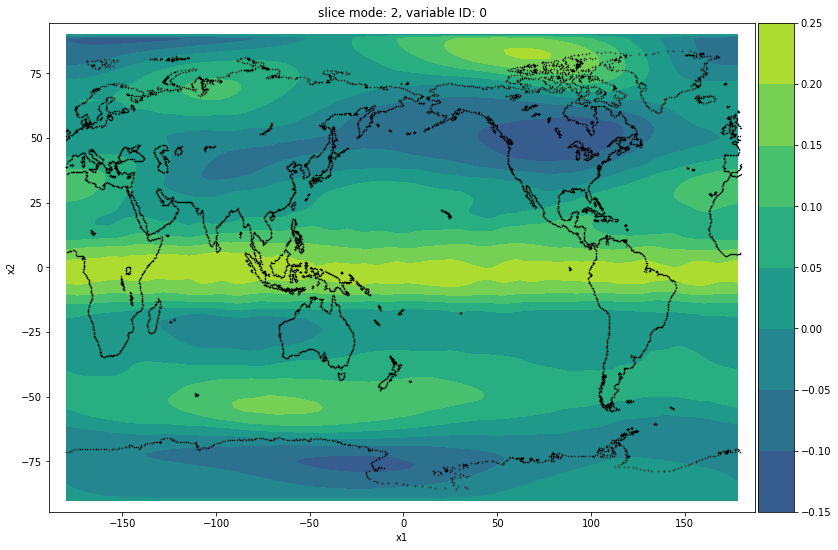

In [11]:
spod.plot_3D_modes_slice_at_frequency(
    freq_required=freq_found, 
    freq=freq, 
    x1=x1-180, 
    x2=x2, 
    x3=x3, 
    slice_dim=2,
    slice_id=2, 
    coastlines='centred', modes_idx=[0,1,2], vars_idx=[0])

We can also plot modes tracers as well as data tracers, that shows the evolution in time of single points in our 3D data. To plot mode tracers, we can use the built-in method: `spod.plot_mode_tracers`, to which we pass the coordinates `coords` we want our tracers at, along with the frequency of the modes we want to visualize `freq_required`, and the frequency vector `freq`. Note that we again pass `modes_idx`, to indicate the modes we want to plot. 

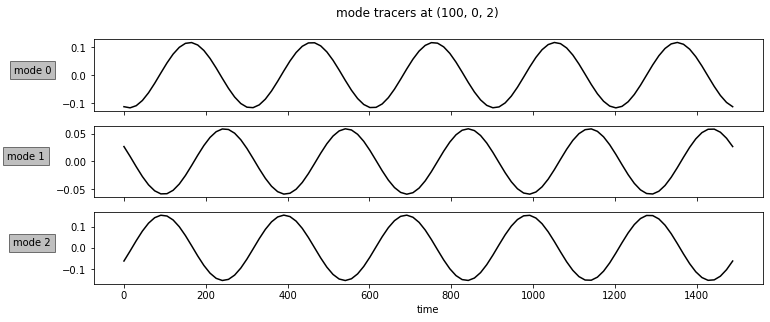

In [12]:
spod.plot_mode_tracers(
    freq_required=freq_found, 
    freq=freq, 
    coords_list=[(100,0,2)], 
    modes_idx=[0,1,2])

Similarly, to plot data tracers, we can use the following line, where we again specify a list of coordinates we want to plot. 

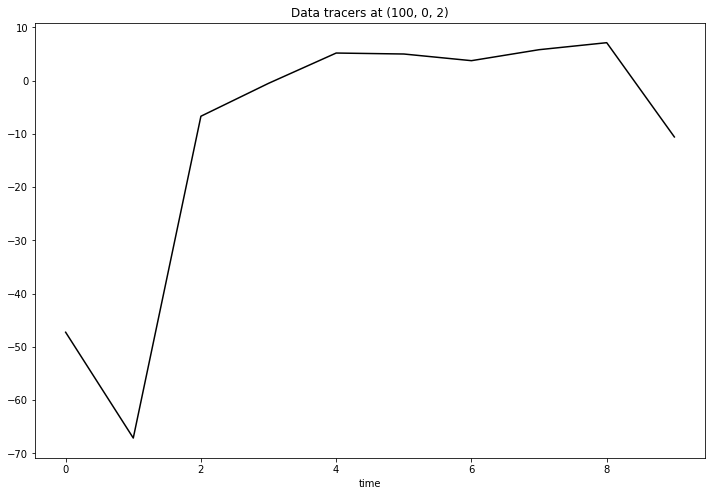

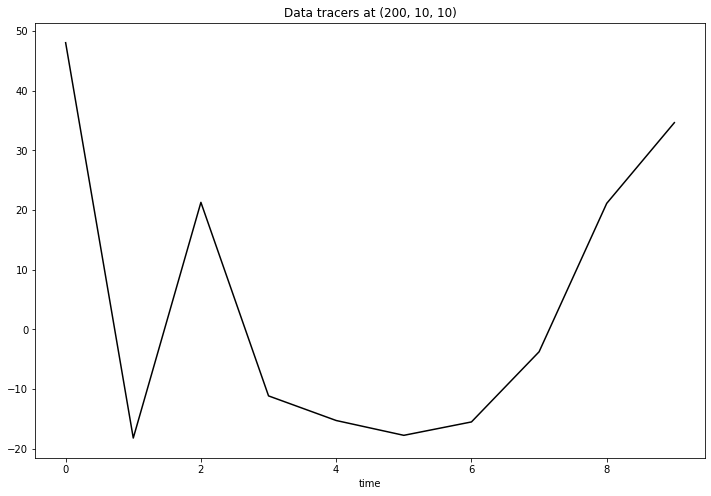

In [13]:
spod.plot_data_tracers(coords_list=[(100,0,2),(200,10,10)])

## Using modes for reduced order modeling

It is possible to use the modes generated by SPOD to construct reduced order models. In particular, we can assume that the original data is composed by a temporal mean and a fluctuating component: 

$$\mathbf{q}(t) = \bar{\mathbf{q}} + \mathbf{q}'(t)$$

We can use a reduced number of modes $\boldsymbol{\Phi}_r$, with $r < n$, where $n$ is the original dimension of the data $\mathbf{q}(t)$ to approximate $\mathbf{q}'(t)$, hence the dynamics of the system. Following [Chu and Schmidt, 2020](https://arxiv.org/pdf/2012.02902.pdf):

- we construct a vector $\tilde{\mathbf{q}}$ that approximates the original data $\mathbf{q}'$ as follows

$$ \tilde{\mathbf{q}} = \boldsymbol{\Phi}_r(\boldsymbol{\Phi}_r^{*} \mathbf{W}\boldsymbol{\Phi}_r)^{-1}\boldsymbol{\Phi}_r^{*}\mathbf{W}\mathbf{q}' = \mathbf{P}\mathbf{q}'$$

- we couple the approximated vector $\tilde{q}$ with the underlying dynamics (eventually approximated) of the problem being studied

$$ \frac{\text{d}}{\text{d}t}\mathbf{q}' = f(\bar{\mathbf{q}}, \mathbf{q}', t) \longrightarrow \frac{\text{d}}{\text{d}t}\tilde{\mathbf{q}} = \mathbf{P}f(\bar{\mathbf{q}}, \tilde{\mathbf{q}}, t)$$

Obviously, the second step depends on the knowledge we have of the system and how well our knowledge approximates the original dynamics.

## Final notes

The results are stored in the results folder defined in the parameter you specified under `params[savedir]`. You can load the results for both modes and eigenvalues, and use any other postprocessing tool that is more suitable to your application. The files are stored in `numpy` binary format `.npy`. There exists several tools to convert them in `netCDF`, `MATLAB` and several other formats that can be better suited to you specific post-processing pipeline.

This tutorial was intended to help you setup your own three-dimensional case. You can play with the parameters we explored above to gain more insights into the capabilities of the library. You can also run on the same data the other two SPOD algorithms implemented as part of this library by simply calling:
- SPOD_analysis = SPOD_low_storage(data=X, params=params, file_handler=False)
- SPOD_analysis = SPOD_streaming(data=X, params=params, file_handler=False)

and compare the results.